### Multivariate Interpolation

Bivariate interpolation with splines can be performed with `interp2d` in the module `scipy.interpolate`.  This is a very simple class that allows only the evaluation method, and has coded three basic spline interpolation modes: `linear`, `cubic` and `quintic`.  It offers no control over knots or weights.  To create a representation of the bivariate spline, the function `interp2d` calls the `Fortran` routine `SURFIT` from the library `FITPACK` (which sadly, it is not actually meant to perform interpolation!).  To evaluate it, it calls the routine `BISPEV`.   It is possible to obtain the `Fortan` representation of the interpolating spline by calling the method `.tck`.

Let us show by example the usage of `interp2d`.  We construct first an interesting bivariate function to interpolate, a random choice of 100 nodes on its domain, and present a visualization:


//anaconda/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
//anaconda/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


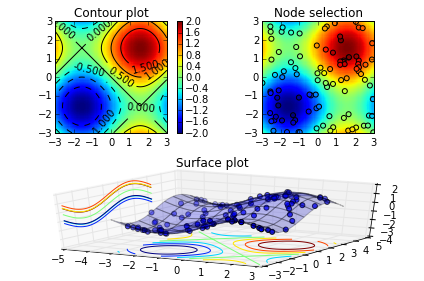

In [1]:
import numpy as np, matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
    
%matplotlib inline

def f(x,y): return np.sin(x) + np.sin(y)

t = np.linspace(-3, 3, 100)
domain = np.meshgrid(t, t)
X, Y = domain
Z = f(*domain)

fig = plt.figure()
ax1 = plt.subplot2grid((2,2), (0,0), aspect='equal')
p = ax1.pcolor(X, Y, Z)
fig.colorbar(p)
CP = ax1.contour(X, Y, Z, colors='k')
ax1.clabel(CP)
ax1.set_title('Contour plot')

nodes = 6 * np.random.rand(100, 2) - 3
xi = nodes[:, 0]
yi = nodes[:, 1]
zi = f(xi, yi)

ax2 = plt.subplot2grid((2,2), (0,1), aspect='equal')
p2 = ax2.pcolor(X, Y, Z)
ax2.scatter(xi, yi, 25, zi)
ax2.set_xlim(-3, 3)
ax2.set_ylim(-3, 3)
ax2.set_title('Node selection')

ax3 = plt.subplot2grid((2,2), (1,0), projection='3d', colspan=2, rowspan=2)
ax3.plot_surface(X, Y, Z, alpha=0.25)
ax3.scatter(xi, yi, zi, s=25)
cset = ax3.contour(X, Y, Z, zdir='z', offset=-4)
cset = ax3.contour(X, Y, Z, zdir='x', offset=-5)
ax3.set_xlim3d(-5, 3)
ax3.set_ylim3d(-3, 5)
ax3.set_zlim3d(-4, 2)
ax3.set_title('Surface plot')

fig.tight_layout()
plt.show()

Piecewise Linear interpolation with these nodes can be then performed as follows:


//anaconda/lib/python2.7/site-packages/scipy/interpolate/fitpack.py:970: RuntimeWarning:     No more knots can be added because the number of B-spline coefficients
    already exceeds the number of data points m. Probably causes: either
    s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=12,13 m=100 fp=0.000724 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


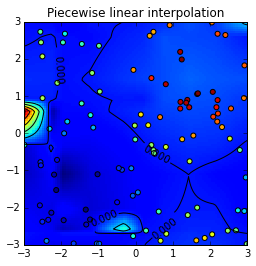

In [2]:
from scipy.interpolate import interp2d

interpolant = interp2d(xi, yi, zi, kind='linear')

plt.figure()
plt.axes().set_aspect('equal')
plt.pcolor(X, Y, interpolant(t, t))
plt.scatter(xi, yi, 25, zi)
CP = plt.contour(X, Y, interpolant(t, t), colors='k')
plt.clabel(CP)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.title('Piecewise linear interpolation')
plt.show()

> If the location of the nodes is not optimal, we are likely to obtain a warning:

>     ....
>     Warning:     No more knots can be added because the number of B-spline coefficients
>         already exceeds the number of data points m. Probably causes: either
>         s or m too small. (fp>s)
> 	    kx,ky=1,1 nx,ny=11,14 m=100 fp=0.002836 s=0.000000
>     ....

> Note in the previous example the evaluation of the interpolant, performed with a call to two one-dimensional arrays.  In general, to evaluate an interpolant `g` computed with `interp2d` on a rectangular grid that can be realized as the Cartesian product of two one-dimensional arrays `tx` of size `n`, and `ty` of size `m`, we issue `g(tx, ty)`: this gives us a two-dimensional array of size `m`-by-`n`.

Note the poor quality of previous result.  In spite of its name, `interp2d` is *not* an actual interpolation!

The quality of the result is, of course, deeply linked to the density and structure of the nodes.  Increasing their number,  or imposing their location on a rectangular grid improves matters. In the case of nodes forming a rectangular grid, an actual interpolation, with a much faster and accurate method is accomplished by means of the class `RectBivariateSpline`. This function is a wrapper to the `Fortran` routine `REGRID` in the library `FITPACK`.  This function allows us to control the number and position of knots, and the weights of the spline.  

Let us choose now 100 nodes on a rectangular grid, and recalculate without introducing any improved selection of knots or weights:

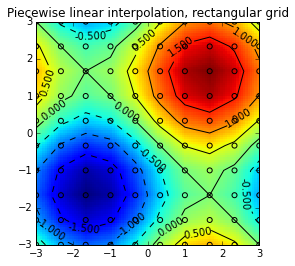

In [3]:
ti = np.linspace(-3, 3, 10)
xi, yi = np.meshgrid(ti, ti)
zi = f(xi, yi)

from scipy.interpolate import RectBivariateSpline

interpolant = RectBivariateSpline(ti, ti, zi, kx=1, ky=1)

plt.figure()
plt.axes().set_aspect('equal')
plt.pcolor(X, Y, interpolant(t, t))
CP = plt.contour(X, Y, interpolant(t, t), colors='k')
plt.clabel(CP)
plt.scatter(xi, yi, 25, zi)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.title('Piecewise linear interpolation, rectangular grid')
plt.show()

> As with the case of `interp2d`, to evaluate an interpolant `g` computed with `RectBivariateSpline` on a rectangular grid that can be realized as the Cartesian product of two one-dimensional arrays `tx` of size `n`, and `ty` of size `m`, we issue `g(tx, ty)`: this gives us a two-dimensional array of size `m`-by-`n`.

The volume integral under the graph is very accurate (the actual integral of the target function in the given domain is zero):

In [4]:
interpolant.integral(-3, 3, -3, 3)

2.636779683484747e-16

Let us examine some of the different pieces of information we receive from this class, in this case:

* The degrees of the interpolant

In [5]:
print interpolant.degrees

(1, 1)


* The sum of squared residuals of the spline approximation returned

In [6]:
print interpolant.fp

print interpolant.get_residual()

0.0
0.0


* The coefficients of the interpolant

In [7]:
np.set_printoptions(precision=5, suppress=True)

print interpolant.get_coeffs()

[-0.28224 -0.86421 -1.13653 -0.98259 -0.46831  0.18607  0.70035  0.85429
  0.58197  0.      -0.86421 -1.44617 -1.71849 -1.56456 -1.05028 -0.39589
  0.11839  0.27232  0.      -0.58197 -1.13653 -1.71849 -1.99082 -1.83688
 -1.3226  -0.66821 -0.15394  0.      -0.27232 -0.85429 -0.98259 -1.56456
 -1.83688 -1.68294 -1.16867 -0.51428  0.       0.15394 -0.11839 -0.70035
 -0.46831 -1.05028 -1.3226  -1.16867 -0.65439 -0.       0.51428  0.66821
  0.39589 -0.18607  0.18607 -0.39589 -0.66821 -0.51428 -0.       0.65439
  1.16867  1.3226   1.05028  0.46831  0.70035  0.11839 -0.15394  0.
  0.51428  1.16867  1.68294  1.83688  1.56456  0.98259  0.85429  0.27232
  0.       0.15394  0.66821  1.3226   1.83688  1.99082  1.71849  1.13653
  0.58197  0.      -0.27232 -0.11839  0.39589  1.05028  1.56456  1.71849
  1.44617  0.86421  0.      -0.58197 -0.85429 -0.70035 -0.18607  0.46831
  0.98259  1.13653  0.86421  0.28224]


* The location of the knots:

In [10]:
interpolant.get_knots()

(array([-3.     , -3.     , -2.33333, -1.66667, -1.     , -0.33333,
         0.33333,  1.     ,  1.66667,  2.33333,  3.     ,  3.     ]),
 array([-3.     , -3.     , -2.33333, -1.66667, -1.     , -0.33333,
         0.33333,  1.     ,  1.66667,  2.33333,  3.     ,  3.     ]))

Smoother results can be obtained with piecewise cubic splines.  In the previous example, we can accomplish this task by setting `kx=3, ky=3`:

Among all possible interpolation with cubic splines, there is a special case that minimizes the curvature.  We have one implementation of this particular case, by means of a clever iterative algorithm that converges to the solution.  It is very fast and robust.  It relies on three key concepts: 

* Delaunay triangulations of the domain using the nodes as vertices,
* Bezier cubic polynomials supported on each triangle using a Cough-Tocher scheme, and
* Estimation and imposition of gradients to minimize curvature.

An implementation of this algorithm is available through the function `CloughTocher2dInterpolator`, in the module `scipy.interpolate`, or through the black-box function `griddata` in the same module, with the option `method='cubic'`.  Let us compare outputs:

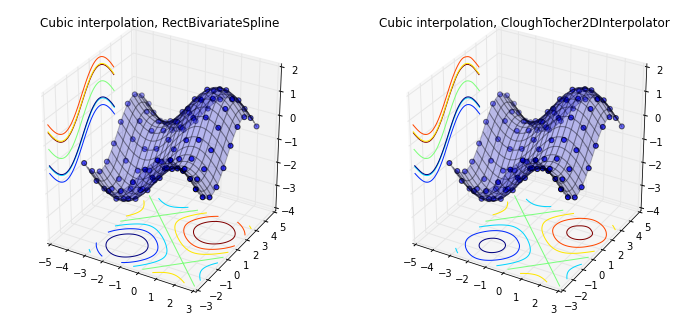

In [11]:
interpolant = RectBivariateSpline(ti, ti, zi, kx=3, ky=3)

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121, projection='3d', aspect='equal')
ax.plot_surface(X, Y, interpolant(t, t), alpha=0.25, rstride=5, cstride=5)
ax.scatter(xi, yi, zi, s=25)
cset = ax.contour(X, Y, interpolant(t, t), zdir='z', offset=-4)
cset = ax.contour(X, Y, interpolant(t, t), zdir='x', offset=-5)
ax.set_xlim3d(-5, 3)
ax.set_ylim3d(-3, 5)
ax.set_zlim3d(-4, 2)
ax.set_title('Cubic interpolation, RectBivariateSpline')
    
from scipy.interpolate import CloughTocher2DInterpolator

nodes = np.dstack((np.ravel(xi), np.ravel(yi))).squeeze()
zi = f(nodes[:, 0], nodes[:, 1])

interpolant = CloughTocher2DInterpolator(nodes, zi)

ax = fig.add_subplot(122,projection='3d', aspect='equal')
ax.plot_surface(X, Y, interpolant(X, Y), alpha=0.25, rstride=5, cstride=5)
ax.scatter(xi, yi, zi, s=25)
cset = ax.contour(X, Y, interpolant(X, Y), zdir='z', offset=-4)
cset = ax.contour(X, Y, interpolant(X, Y), zdir='x', offset=-5)
ax.set_xlim3d(-5, 3)
ax.set_ylim3d(-3, 5)
ax.set_zlim3d(-4, 2)
ax.set_title('Cubic interpolation, CloughTocher2DInterpolator')
plt.show()

> Unlike the cases of `interp2d` and `RectBivariateSpline`, to evaluate an interpolant `g` computed with `CloughTocher2DInterpolator` on a rectangular grid `X, Y = domain`,  we issue `g(X, Y)` or `g(*domain)`.

The black-box procedural function `griddata` also allows us to access piecewise linear interpolation in multiple dimensions, as well as multidimensional nearest-neighbor interpolation.

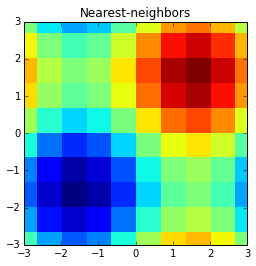

In [12]:
from scipy.interpolate import griddata

interpolated_Z = griddata(nodes, zi, (X, Y), method='nearest')

plt.figure()
plt.axes().set_aspect('equal')
plt.pcolor(X, Y, interpolated_Z)
plt.title('Nearest-neighbors')
plt.show()

There is yet one more interpolation mode to consider: *radial basis function interpolation*.  The aim is to interpolate with a linear combination of radial functions of the form `fk(x,y) = g(sqrt((x-xk)**2 + (y-yk)**2))`, centered at the points `(xk, yk)`, for the same function `g`.  We may choose among seven standard functions `g` (listed below), or even choose our own.

* `'multiquadric'`: `g(r) = sqrt((r/self.epsilon)**2 + 1)`
* `'inverse'`: `g(r) = 1.0/sqrt((r/self.epsilon)**2 + 1)`
* `'gaussian'`: `g(r) = exp(-(r/self.epsilon)**2)`
* `'linear'`: `g(r) = r`
* `'cubic'`: `g(r) = r**3`
* `'quintic'`: `g(r) = r**5`
* `'thin_plate'`: `g(r) = r**2 * log(r)`

The implementation is performed through the class `Rbf`.  It can be initialized as usual with nodes, and their evaluations.  We also need to include the choice of radial function, and if necessary, the value of the parameter `epsilon` affecting the size of the _bumps_:

Let us run a couple of interpolations: first by means of radial Gaussians with standard deviation `epsilon = 2.0`, and then with a radial function based on a sinc.  Let us also go back to random nodes:


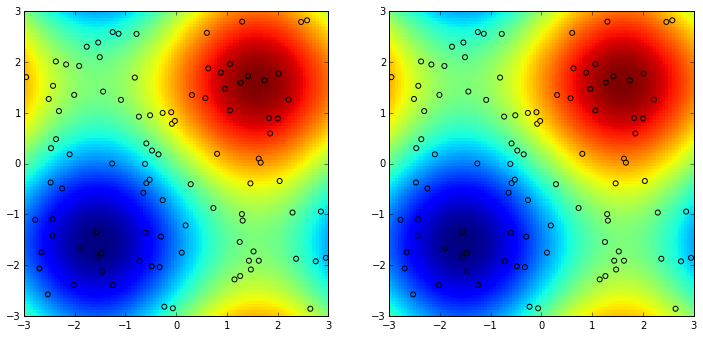

In [21]:
from scipy.interpolate import Rbf

nodes = 6 * np.random.rand(100, 2) - 3
xi = nodes[:, 0]
yi = nodes[:, 1]
zi = f(xi, yi)

interpolant = Rbf(xi, yi, zi, function='gaussian', epsilon=2.0)

plt.figure(figsize=(12,6))
plt.subplot(121, aspect='equal')
plt.pcolor(X, Y, interpolant(X, Y))
plt.scatter(xi, yi, 25, zi)
plt.xlim(-3, 3)
plt.ylim(-3, 3)

interpolant = Rbf(xi, yi, zi, function = np.sinc)


plt.subplot(122, aspect='equal'); \
   ....: plt.pcolor(X, Y, interpolant(X, Y)); \
   ....: plt.scatter(xi, yi, 25, zi); \
   ....: plt.xlim(-3, 3); \
   ....: plt.ylim(-3, 3); \
   ....: plt.show()